In [1]:
import os 
import math 
import random 
import numpy as np 
import tensorflow as tf 
import cv2 
import sys 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
sys.path.append('/home/mt/learn/SSD-Tensorflow-master/')
from nets import ssd_vgg_300, ssd_common, np_methods 
from preprocessing import ssd_vgg_preprocessing 
from notebooks import visualization 


slim = tf.contrib.slim # TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!! 
gpu_options = tf.GPUOptions(allow_growth=True) 
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options) 
isess = tf.InteractiveSession(config=config)


In [2]:
# 定义数据格式，设置占位符 
net_shape = (300, 300) 
# 输入图像的通道排列形式，'NHWC'表示 [batch_size,height,width,channel] 
data_format = 'NHWC' 
# 预处理，以Tensorflow backend, 将输入图片大小改成 300x300，作为下一步输入 
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3)) 
# 数据预处理，将img_input输入的图像resize为300大小，labels_pre,bboxes_pre,bbox_img待解析 
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval( img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE) 
# 拓展为4维变量用于输入 
image_4d = tf.expand_dims(image_pre, 0) 


# 定义SSD模型 # 是否复用，目前我们没有在训练所以为None 
reuse = True if 'ssd_net' in locals() else None 
# 调出基于VGG神经网络的SSD模型对象，注意这是一个自定义类对象 
ssd_net = ssd_vgg_300.SSDNet() 
# 得到预测类和预测坐标的Tensor对象，这两个就是神经网络模型的计算流程 
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)): 
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse) 
# 导入新训练的模型参数 
ckpt_filename = '../train_model/model.ckpt-1000' 
# 注意xxx代表的数字是否和文件夹下的一致 # ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt' 
isess.run(tf.global_variables_initializer()) 
saver = tf.train.Saver() 
saver.restore(isess, ckpt_filename) 
# 在网络模型结构中，提取搜索网格的位置 
# 根据模型超参数，得到每个特征层（这里用了6个特征层，分别是4，7，8，9，10，11）的anchors_boxes 
ssd_anchors = ssd_net.anchors(net_shape)


INFO:tensorflow:Restoring parameters from ../train_model/model.ckpt-1000


In [23]:
def process_image(img, select_threshold=0.25, nms_threshold=.01, net_shape=(300, 300)): 
    # select_threshold：box阈值——每个像素的box分类预测数据的得分会与box阈值比较，高于一个box阈值则认为这个box成功框到了一个对象 
    # nms_threshold：重合度阈值——同一对象的两个框的重合度高于该阈值，则运行下面去重函数 
    # 执行SSD模型，得到4维输入变量，分类预测，坐标预测，rbbox_img参数为最大检测范围，本文固定为[0,0,1,1]即全图 
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img], feed_dict={img_input: img}) 
    # ssd_bboxes_select()函数根据每个特征层的分类预测分数，归一化后的映射坐标， 
    # ancohor_box的大小，通过设定一个阈值计算得到每个特征层检测到的对象以及其分类和坐标 
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select( rpredictions, rlocalisations, ssd_anchors, select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    # 检测有没有超出检测边缘 
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes) 
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400) 
    # 去重，将重复检测到的目标去掉 
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold) 
    # 将box的坐标重新映射到原图上（上文所有的坐标都进行了归一化，所以要逆操作一次） 
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes) 
    return rclasses, rscores, rbboxes


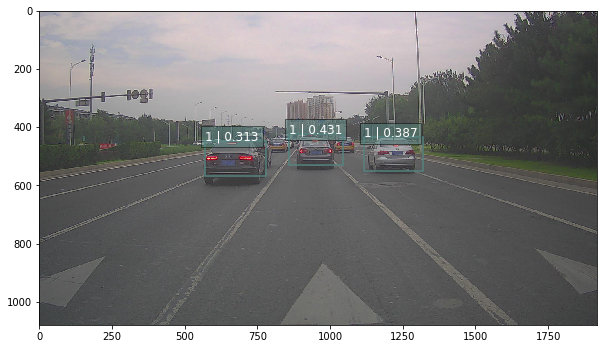

In [25]:
# 测试的文件夹 
path = '/home/mt/learn/SSD-Tensorflow-master/demo1/train/images/' 
image_names = sorted(os.listdir(path)) 
# 文件夹中的第几张图，-1代表最后一张 
img = mpimg.imread(path + image_names[1]) 
rclasses, rscores, rbboxes = process_image(img) 
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma) 
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
